In [1]:
import os
import random
from hashlib import sha256
from itertools import accumulate

import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

# fix gpu memory management 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# enable reproducibility
SEED = 42
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

Text(0.5, 1.0, 'ship')

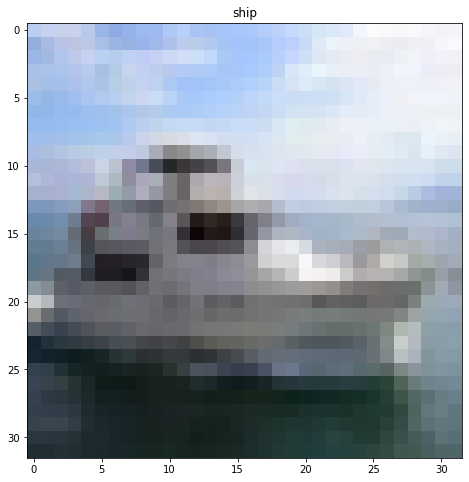

In [3]:
idx = np.random.choice(len(x_train))
plt.imshow(x_train[idx])
plt.title(labels[y_train[idx, 0]])

In [4]:
class Signature:
    def __init__(self, data, model, ratio=0.01, hash_fn=sha256):
        self.rand_gen = self.gen_state(data, hash_fn)
        n_total = model.count_params()
        n_frozen = int(ratio*n_total)
        self.weights = self.gen_weights(n_frozen)
        self.idx = self.gen_indices(n_frozen, n_total)
        print(f'Created signature with {n_frozen} parameters')
    
    def gen_state(self, data, hash_fn):
        """
        Generates a random state that can be used as number generator from a bytes object
        """
        h = hash_fn(data).hexdigest()
        seed = int(h, 16) % pow(2, 32) # random state needs an integer between 0 and 2^32-1 
        return np.random.RandomState(seed)
    
    def gen_weights(self, n):
        """
        Generate size random weights from a normal distribution seeded with seed
        """
        return self.rand_gen.normal(loc=0, scale=0.1, size=n).astype('float32')
    
    def gen_indices(self, n: int, upper_bound:int, distribution="uniform"):
        """
        Generate n indices in the interval [0, upper_bound-1] from a uniform distribution seeded with seed
        """
        idx = np.arange(upper_bound)
        if distribution == "uniform":
            return self.rand_gen.choice(idx, n, replace=False)
        else:
            print(distribution)
            raise NotImplementedError()

In [5]:
class WeightsFreezer(tf.keras.callbacks.Callback):
    def __init__(self, signature):
        self.sig = signature
        
    def on_batch_end(self, batch, logs):
        self.apply_weights()
        
    def apply_weights(self):
        """
        Replaces the model weights at indices by weights
        """
        model_weights = self.model.get_weights()
        shapes = [layer.shape for layer in model_weights]
        flat_weights = [layer.flatten() for layer in model_weights]
        # keeping the last cut index creates an empty split, so we do not consider it
        cuts = list(accumulate(len(layer) for layer in flat_weights[:-1]))
        flat_weights = np.concatenate(flat_weights)   
        flat_weights[self.sig.idx] = self.sig.weights
        rebuilt_weights = np.hsplit(flat_weights, cuts)
        rebuilt_weights = [layer.reshape(shapes[i]) for i, layer in enumerate(rebuilt_weights)]
        self.model.set_weights(rebuilt_weights)

In [6]:
# https://arxiv.org/pdf/1608.06037.pdf
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, MaxPooling2D, Dropout, ReLU
from tensorflow.keras.losses import SparseCategoricalCrossentropy

class SimpleNet(models.Sequential):
    
    def __init__(self):
        super().__init__()
        self.initialize_layers()
        loss_fn = SparseCategoricalCrossentropy(from_logits=True)
        self.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
        print(f'Model compiled with {self.count_params():,} parameters')
        self.history = []
        
    def initialize_layers(self):
        kernel_size = 3
        drop_rate = 0.2
        pool_size = 2
        
        # Block 1
        self.add(Conv2D(64, kernel_size, padding="same", input_shape=x_train.shape[1:]))
        self.add(BatchNormalization())
        self.add(ReLU())
        self.add(Dropout(drop_rate))

        # Block 2
        for _ in range(3):
            self.add(Conv2D(128, kernel_size, padding="same"))
            self.add(BatchNormalization())
            self.add(ReLU())
            self.add(Dropout(drop_rate))
        self.add(MaxPooling2D())


        # Block 3
        for _ in range(2):
            self.add(Conv2D(128, kernel_size, padding="same"))
            self.add(BatchNormalization())
            self.add(ReLU())
            self.add(Dropout(drop_rate))

        # Block 4
        self.add(Conv2D(128, kernel_size, padding="same"))
        self.add(BatchNormalization())
        self.add(ReLU())
        self.add(Dropout(drop_rate))
        self.add(MaxPooling2D())

        # Block 5
        for _ in range(2):
            self.add(Conv2D(128, kernel_size, padding="same"))
            self.add(BatchNormalization())
            self.add(ReLU())
            self.add(Dropout(drop_rate))
        self.add(MaxPooling2D())

        # Block 6
        self.add(Conv2D(128, kernel_size, padding="same"))
        self.add(BatchNormalization())
        self.add(ReLU())
        self.add(Dropout(drop_rate))

        # Block 7
        self.add(Conv2D(128, 1, padding="same"))
        self.add(BatchNormalization())
        self.add(ReLU())
        self.add(Dropout(drop_rate))

        # Block 8
        self.add(Conv2D(128, 1, padding="same"))
        self.add(BatchNormalization())
        self.add(ReLU())
        self.add(Dropout(drop_rate))
        self.add(MaxPooling2D())

        # Block 9
        self.add(Conv2D(128, kernel_size, padding="same"))
        self.add(BatchNormalization())
        self.add(ReLU())
        self.add(Dropout(drop_rate))

        # Classifier block    
        self.add(Flatten()),
        self.add(Dense(np.unique(y_train).size, activation='softmax'))
        
    def verify(self, signature):
        """
        Verifies the signature of the model
        """
        flat_weights = [layer.flatten() for layer in self.get_weights()]
        flat_weights = np.concatenate(flat_weights)
        return np.abs(flat_weights[signature.idx] - signature.weights).max() < 1e-8
    
    def train(self, *args, **kwargs):
        self.history = self.fit(*args, **kwargs)
    
    def plot_training(self):
        if not self.history:
            raise ValueError("Model has not been trained yet")
        else:
            fig, ax = plt.subplots(1, 2)
    
            ax[0].plot(history.history['accuracy'], label='Train')
            ax[0].plot(history.history['val_accuracy'], label='Test')
            ax[0].set(xlabel='Epoch', ylabel='Accuracy', title='Model accuracy')
            ax[0].legend(loc='upper left')

            ax[1].plot(history.history['loss'], label='Train')
            ax[1].plot(history.history['val_loss'], label='Test')
            ax[1].set(xlabel='Epoch', ylabel='Loss', title='Model loss')
            ax[1].legend(loc='upper left')

            return fig, ax

In [7]:
model = SimpleNet()
sig = Signature(b'Some block information', model, ratio=0.0001)
other_sig = Signature(b"Some other block information", model)
wf = WeightsFreezer(sig)

Model compiled with 1,448,458 parameters
Created signature with 144 parameters
Created signature with 14484 parameters


In [ ]:
history = model.fit(x_train, y_train, steps_per_epoch=None, batch_size=100, 
                    epochs=50, validation_data=(x_test,y_test), callbacks=[wf])

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 77s 2ms/sample - loss: 2.1013 - accuracy: 0.3498 - val_loss: 2.1305 - val_accuracy: 0.3188
Epoch 2/50
50000/50000 [==============================] - 75s 2ms/sample - loss: 1.9799 - accuracy: 0.4771 - val_loss: 2.0649 - val_accuracy: 0.3881
Epoch 3/50
50000/50000 [==============================] - 75s 2ms/sample - loss: 1.8980 - accuracy: 0.5595 - val_loss: 2.2150 - val_accuracy: 0.2354
Epoch 4/50
50000/50000 [==============================] - 75s 2ms/sample - loss: 1.8480 - accuracy: 0.6116 - val_loss: 1.9840 - val_accuracy: 0.4734
Epoch 5/50
50000/50000 [==============================] - 77s 2ms/sample - loss: 1.8176 - accuracy: 0.6411 - val_loss: 1.9559 - val_accuracy: 0.5023
Epoch 6/50
33800/50000 [===================>..........] - ETA: 23s - loss: 1.7947 - accuracy: 0.6653

In [ ]:
model.verify(sig)

In [ ]:
model.verify(other_sig)

In [ ]:
model.save('models/50epochs_ratio4.h5')

In [ ]:
_, _ = model.plot_training()